In [1]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from statsmodels.api import OLS
import plotly.graph_objects as go

SEED = 17
compare_metric_name = 'RMSE'

# Load dataset

In [ ]:
def read_table_from_db(table_name):
    df = pd.read_sql(f'SELECT * FROM {table_name}', con=DB)
    return df

In [2]:
data = read_table_from_db('airbnb_data')
target_feature = 'log_price'
independent_features = data.columns.drop(target_feature)
data.head()

,host_is_superhost,host_has_profile_pic,host_identity_verified,accommodates,bedrooms,beds,minimum_nights,maximum_nights,availability_30,availability_365,...,number_of_education_institutions_within_100m,distance_to_nearest_cultural_institution_m,number_of_cultural_institutions_within_100m,distance_to_nearest_recreation_point_m,number_of_recreation_points_within_100m,distance_to_nearest_religious_institution_m,number_of_religious_institutions_within_100m,distance_to_nearest_health_institution_m,number_of_health_institutions_within_100m,distance_to_nearest_main_attraction_m
0,0,1,1,1,0.0,1.0,30,1125,0,248,...,0,264.899,0,74.9974,1,113.311,0,748.997,0,497.315
1,0,1,1,2,1.0,1.0,30,150,0,233,...,1,114.917,0,157.0960,0,143.338,0,798.512,0,5687.510
2,0,1,1,4,2.0,2.0,30,730,0,121,...,1,419.009,0,375.3300,0,201.431,0,607.539,0,5139.470
3,1,1,1,3,2.0,1.0,30,730,0,157,...,1,441.078,0,122.0370,0,489.013,0,867.072,0,5022.830
4,0,1,1,1,1.0,1.0,30,180,30,365,...,0,571.057,0,108.9370,0,157.284,0,262.918,0,2800.150


## Split dataset

In [3]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=SEED)

# Import saved models

In [4]:
with open("saved_models/model_LR.pkl", "rb") as fp:
    model_LR = pickle.load(fp)
with open("saved_models/model_XGB.pkl", "rb") as fp:
    model_XGB = pickle.load(fp)
with open("saved_models/model_NN.pkl", "rb") as fp:
    model_NN = pickle.load(fp)

In [5]:
for result in [model_LR, model_XGB, model_NN]:
    pred = pd.Series(result["predictions"], index=result["indices"]).sort_index()
    test_data[f"pred {result['name']}"] = pred
pred_names = [f"pred {model['name']}" for model in [model_XGB, model_NN]]

In [6]:
test_data[pred_names].corr()

,pred XGBoost,pred Neural Network
pred XGBoost,1.000000,0.964962
pred Neural Network,0.964962,1.000000


The correlation between models predictions is very high.

In [7]:
test_data[pred_names+[target_feature]].corr()

,pred XGBoost,pred Neural Network,log_price
pred XGBoost,1.000000,0.964962,0.894187
pred Neural Network,0.964962,1.000000,0.870160
log_price,0.894187,0.870160,1.000000


The difference between samples predictions are similar across models.

So we can use the average of the predictions to improve the final score.

In [8]:
test_data["pred_mean"] = test_data[pred_names].mean(axis=1)
test_results = root_mean_squared_error(test_data[target_feature], test_data["pred_mean"])
print(f"RMSE for mean prediction: {test_results}")

RMSE for mean prediction: 0.3775083617666763


In [9]:
OLS(test_data[target_feature], test_data[pred_names]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              log_price   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                          6.162e+05
Date:                Sun, 19 Jan 2025   Prob (F-statistic):                        0.00
Time:                        17:14:53   Log-Likelihood:                         -2787.4
No. Observations:                6565   AIC:                                      5579.
Df Residuals:                    6563   BIC:                                      5592.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
pred XGBoost            0.8920      0.024     37.271      0.000       0.845       0.939
pred Neural Network     0.1100      0.024      4.600      0.000       0.063       0.157
==============================================================================
Omnibus:                     2278.847   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            41812.134
Skew:                           1.188   Prob(JB):                         0.00
Kurtosis:                      15.133   Cond. No.                         53.0
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
test_data["pred Stacking"] = 0.8920*test_data['pred XGBoost'] + 0.1100*test_data['pred Neural Network']
test_results = root_mean_squared_error(test_data[target_feature], test_data["pred Stacking"])
print(f"RMSE for regression prediction: {test_results}")

RMSE for regression prediction: 0.3699607720656874


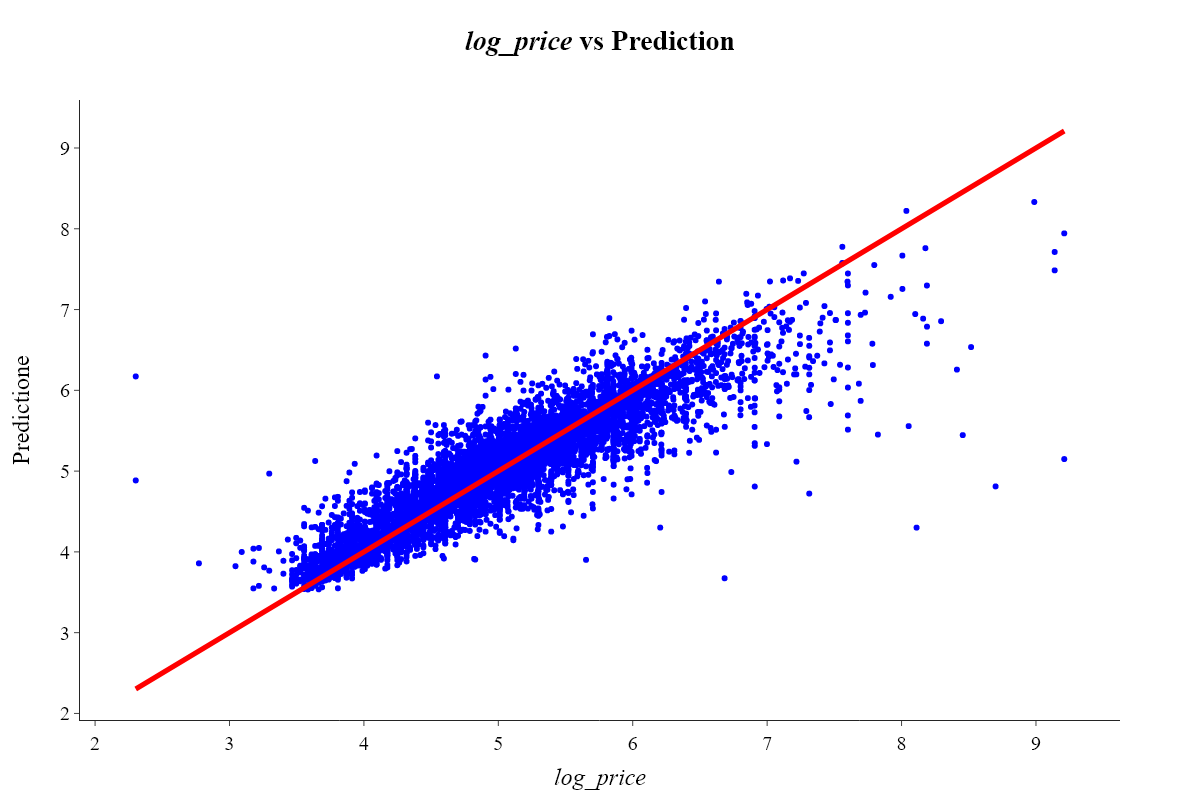

In [11]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_data[target_feature], y=test_data["pred Stacking"], mode='markers', marker=dict(color='blue'), showlegend=False))
fig.add_trace(go.Scatter(x=test_data[target_feature], y=test_data[target_feature], mode='lines', marker=dict(color='red'), line=dict(width=5), showlegend=False))
fig.update_layout(template="simple_white", width=1200, height=800, title="<b><i>log_price</i> vs Prediction</b>", title_x=0.5, xaxis_title="<i>log_price</i>", yaxis_title="Predictione", barmode="group", font=dict(family="Times New Roman",size=20,color="Black"))
fig.show("png")

# Compare models

In [82]:
metrics = {
    "MSE": lambda y_true, y_pred: ((y_true - y_pred) ** 2).mean(),
    "RMSE": lambda y_true, y_pred: ((y_true - y_pred) ** 2).mean() ** 0.5,
    "MAE": lambda y_true, y_pred: (y_true - y_pred).abs().mean()
}
results_df = pd.DataFrame(index=[compare_metric_name], columns=[model['name'] for model in [model_LR, model_XGB, model_NN]]+["Stacking"])
for model_name in results_df.columns:
    for metric_name, metric_func in metrics.items():
        results_df.loc[metric_name, model_name] = metric_func(test_data[target_feature], test_data[f"pred {model_name}"])
results_df

,Linear Regression,XGBoost,Neural Network,Stacking
RMSE,0.481297,0.370699,0.407244,0.369961
MSE,0.231647,0.137418,0.165848,0.136871
MAE,0.350654,0.25734,0.289807,0.257458


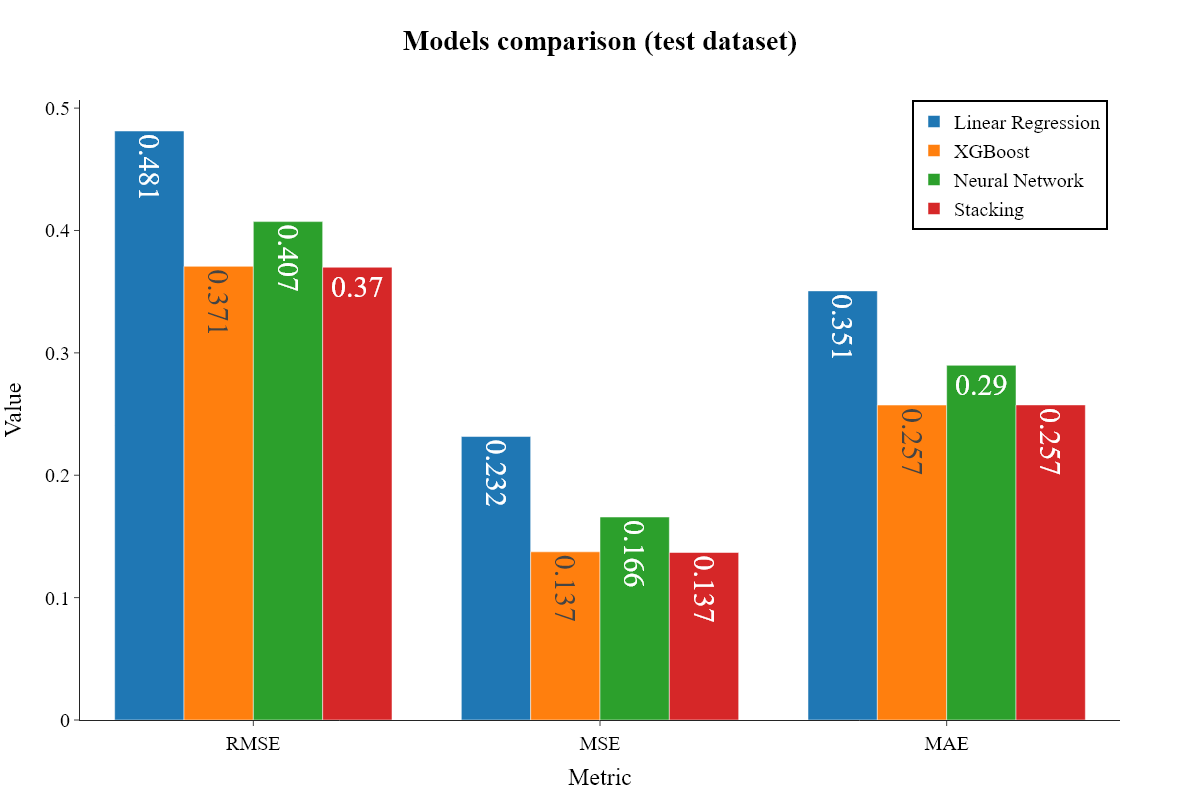

In [83]:
fig = go.Figure()
for model_name in results_df.columns:
    fig.add_trace(go.Bar(x=results_df.index, y=results_df[model_name], name=model_name, text=[round(value, 3) for value in results_df[model_name]], textposition="auto", textfont=dict(size=30)))
fig.update_layout(template="simple_white", width=1200, height=800, title="<b>Models comparison (test dataset)<b>", title_x=0.5, xaxis_title="Metric", yaxis_title="Value", barmode="group", font=dict(family="Times New Roman",size=20,color="Black"))
fig.update_layout(legend=dict(x=0.8, y=1.0, bgcolor="rgba(255, 255, 255, 0)", bordercolor="Black", borderwidth=2))
fig.show("png")

**Notes:**
- Linear Regression (benchmark model) has the highest error across all metrics, indicating that it performs worse compared to the other models.
- For the MSE metric, the difference between Neural Network and XGBoost is higher in terms of percentage (20.69%) compared to MAE (12.62%). It suggests that Neural Network has a problem with correctly predicting outliers or more extreme values.
- Both XGBoost and Neural Network significantly outperform Linear Regression.
- The Stacking model achieves almost the same performance as XGBoost, likely because after fitting Meta Learner which in this case is Linear Regression, the model relies heavier on the XGBoost model which is more accurate than the Neural Network.
- To improve Stacking model performance, we can try to use more complex models as Meta Learner or use more models in the first layer, for instance LightGBM, CatBoost, or Random Forest.